In [54]:
import yfinance as yf
import pandas as pd
import numpy as np
import hvplot.pandas
from finta import TA

**YFinance:**

In [55]:
# set ticker ('BTC-USD', 'ETH-USD')
ticker = 'ETH-USD'
cc = yf.Ticker(f"{ticker}")

In [56]:
# set dates for historical data
start = '2018-02-01'
end = '2023-01-24'

hist = cc.history(start=f"{start}", end=f"{end}")
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-02-01 00:00:00+00:00,1119.369995,1161.349976,984.818970,1036.790039,5261680128,0.0,0.0
2018-02-02 00:00:00+00:00,1035.770020,1035.770020,757.979980,915.784973,6713290240,0.0,0.0
2018-02-03 00:00:00+00:00,919.210999,991.942993,847.690002,964.018982,3243480064,0.0,0.0
2018-02-04 00:00:00+00:00,964.666992,969.031982,805.064026,834.682007,2997090048,0.0,0.0
2018-02-05 00:00:00+00:00,834.958008,856.645996,644.598999,697.950989,4269530112,0.0,0.0


In [57]:
# just close column
historical = pd.DataFrame(hist)
historical_close = historical.drop(['Open','High', 'Low','Volume', 'Dividends', 'Stock Splits'], axis=1)
historical_close.head()

,Close
Date,
2018-02-01 00:00:00+00:00,1036.790039
2018-02-02 00:00:00+00:00,915.784973
2018-02-03 00:00:00+00:00,964.018982
2018-02-04 00:00:00+00:00,834.682007
2018-02-05 00:00:00+00:00,697.950989


**Fear and Greed API:**

In [58]:
import requests

In [59]:
r = requests.get('https://api.alternative.me/fng/?limit=0')

In [60]:
# select 'data' and add to a dataframe
fg_df = pd.DataFrame(r.json()['data'])

Task was destroyed but it is pending!
task: <Task pending name='Task-8' coro=<WebSocketCommonProtocol.transfer_data() running at c:\Users\Max Work\anaconda3\envs\dreambuilder\lib\site-packages\websockets\legacy\protocol.py:979> wait_for=<Future pending cb=[shield.<locals>._outer_done_callback() at c:\Users\Max Work\anaconda3\envs\dreambuilder\lib\asyncio\tasks.py:902, Task.__wakeup()]> cb=[Task.__wakeup()]>
Task was destroyed but it is pending!
task: <Task pending name='Task-10' coro=<WebSocketCommonProtocol.close_connection() running at c:\Users\Max Work\anaconda3\envs\dreambuilder\lib\site-packages\websockets\legacy\protocol.py:1314> wait_for=<Task pending name='Task-8' coro=<WebSocketCommonProtocol.transfer_data() running at c:\Users\Max Work\anaconda3\envs\dreambuilder\lib\site-packages\websockets\legacy\protocol.py:979> wait_for=<Future pending cb=[shield.<locals>._outer_done_callback() at c:\Users\Max Work\anaconda3\envs\dreambuilder\lib\asyncio\tasks.py:902, Task.__wakeup()]> cb

In [61]:
# convert 'value' to int
fg_df.value = fg_df.value.astype(int)

# convert time format to datetime
fg_df.timestamp = pd.to_datetime(fg_df.timestamp, unit='s' )

# set date as index
fg_df.set_index('timestamp', inplace=True)

In [62]:
# drop all columns except 'value'
fg_df = fg_df.drop(['value_classification', 'time_until_update'], axis=1)

# flip oldest data to the top
fg_df = fg_df[::-1]

# convert date format to match 'historical_close'
fg_df.index = pd.to_datetime(fg_df.index).tz_localize('Etc/UCT')

In [63]:
fg_df.head()

,value
timestamp,
2018-02-01 00:00:00+00:00,30
2018-02-02 00:00:00+00:00,15
2018-02-03 00:00:00+00:00,40
2018-02-04 00:00:00+00:00,24
2018-02-05 00:00:00+00:00,11


**Combined:**

In [64]:
# rename index to match fg_df
historical.index.name = 'timestamp'

# combine historical price data with historical fear and greed
combined_df = pd.concat([fg_df, historical_close], axis=1, join='outer')

combined_df.head()

,value,Close
timestamp,,
2018-02-01 00:00:00+00:00,30.0,1036.790039
2018-02-02 00:00:00+00:00,15.0,915.784973
2018-02-03 00:00:00+00:00,40.0,964.018982
2018-02-04 00:00:00+00:00,24.0,834.682007
2018-02-05 00:00:00+00:00,11.0,697.950989


**Backtest:**

In [65]:
combined_df_ = combined_df.copy()

# add 'change' column using pct_change on 'Close'
combined_df_['change'] = combined_df_['Close'].pct_change()
combined_df_.tail()

,value,Close,change
timestamp,,,
2023-01-22 00:00:00+00:00,53.0,1628.382080,0.000777
2023-01-23 00:00:00+00:00,50.0,1628.251099,-0.000080
2023-01-24 00:00:00+00:00,52.0,NaN,0.000000
2023-01-25 00:00:00+00:00,51.0,NaN,0.000000
2023-01-26 00:00:00+00:00,54.0,NaN,0.000000


**Algorithm Logic:**

- position 1.0 = Long Crypto (uptrend)

- position -1.0 = Short Crypto (downtrend)

- position 0.0 = Hold Stablecoin (no trend)

In [66]:
# algorithm

combined_df_['position'] = 0

# short when f&g is over 94 (f&g > 94 = -1)
for index, row in combined_df_.iterrows():
    if row['value'] >= 95:
        combined_df_.loc[index, 'position'] = -1.0

# long when f&g is over 45 and under 94 (93 > f&g > 45 = 1)
    elif row['value'] >= 46:
        combined_df_.loc[index, 'position'] = 1.0

# short when f&g is over 24 and less than 46 (46 > f&g > 24 = -1)
    elif row['value'] >= 25:
        combined_df_.loc[index, 'position'] = -1.0
# hold stables under 25 (f&g < 23 = 0.0)
    elif row['value'] < 25:
        combined_df_.loc[index, 'position'] = 0

combined_df_ = combined_df_.dropna()
combined_df_.head(15)

,value,Close,change,position
timestamp,,,,
2018-02-02 00:00:00+00:00,15.0,915.784973,-0.116711,0
2018-02-03 00:00:00+00:00,40.0,964.018982,0.052670,-1
2018-02-04 00:00:00+00:00,24.0,834.682007,-0.134164,0
2018-02-05 00:00:00+00:00,11.0,697.950989,-0.163812,0
2018-02-06 00:00:00+00:00,8.0,793.122009,0.136358,0
2018-02-07 00:00:00+00:00,36.0,757.067993,-0.045458,-1
2018-02-08 00:00:00+00:00,30.0,817.807007,0.080229,-1
2018-02-09 00:00:00+00:00,44.0,883.864990,0.080775,-1
2018-02-10 00:00:00+00:00,54.0,860.414978,-0.026531,1


In [67]:
# number of each position
combined_df_['position'].value_counts()

-1    673
 1    648
 0    493
Name: position, dtype: int64

**Returns:**

In [68]:
# calculate returns
strategy_returns = combined_df_.position.shift() * combined_df_.change

In [69]:
# plot to compare
fg_strat_plt = (strategy_returns +1).cumprod().hvplot(label = 'FG_strat')
cc_returns_plt = (combined_df_.change +1).cumprod().hvplot(label = 'CC')
fg_strat_plt * cc_returns_plt


:Overlay
   .Curve.FG_strat :Curve   [timestamp]   (0)
   .Curve.CC       :Curve   [timestamp]   (change)

In [70]:
# returns
fg_return = (strategy_returns + 1).cumprod()
cc_return = (combined_df_.change + 1).cumprod()
fg_final = fg_return[-1]
cc_final = cc_return[-1]
print(f'Fear and Greed strategy returns:  {round(fg_final, 2)}')
print(f'CC returns:  {round(cc_final, 2)}')

Fear and Greed strategy returns:  53.4
CC returns:  1.51


In [71]:
initial_investment = 1000

fg_inv_returns  = initial_investment * fg_final
cc_inv_returns = initial_investment * cc_final

print(f"Buying ${initial_investment} and holding: ${round(cc_inv_returns, 2)}")
print(f"${initial_investment} with fear and greed strategy: ${round(fg_inv_returns, 2)}")

Buying $1000 and holding: $1513.9
$1000 with fear and greed strategy: $53402.02


**Machine Learning:**

In [72]:
import pandas_ta as pa
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [73]:
# copy and clean dataframe
combined_ml = combined_df_.copy()
combined_ml['RSI'] = pa.rsi(combined_ml.Close, length=16)
combined_ml['Signal'] = combined_ml['position']
combined_ml = combined_ml.drop(["Close", "change", "position"],axis=1)
combined_ml = combined_ml.dropna()
combined_ml.tail()

,value,RSI,Signal
timestamp,,,
2023-01-19 00:00:00+00:00,45.0,73.405640,-1
2023-01-20 00:00:00+00:00,51.0,79.049592,1
2023-01-21 00:00:00+00:00,53.0,73.952890,1
2023-01-22 00:00:00+00:00,53.0,74.022080,1
2023-01-23 00:00:00+00:00,50.0,74.000351,1


In [74]:
# Dataframe
model_df = pd.DataFrame(combined_ml)
model_df = model_df.dropna()

In [75]:
# features dataframe
X = model_df[['RSI', 'value']].shift().dropna()
X.head(10)

,RSI,value
timestamp,,
2018-02-19 00:00:00+00:00,53.324972,63.0
2018-02-20 00:00:00+00:00,55.183005,67.0
2018-02-21 00:00:00+00:00,50.018759,74.0
2018-02-22 00:00:00+00:00,45.743818,54.0
2018-02-23 00:00:00+00:00,42.570200,44.0
2018-02-24 00:00:00+00:00,47.902109,39.0
2018-02-25 00:00:00+00:00,45.810314,31.0
2018-02-26 00:00:00+00:00,46.264407,33.0
2018-02-27 00:00:00+00:00,48.871824,37.0


In [76]:
# Create the target set (-1 = Short, 0 = Stables, 1 = Long)
y = model_df['Signal']
y.value_counts()

-1    666
 1    643
 0    489
Name: Signal, dtype: int64

In [77]:
# start of the training period
training_begin = X.index.min()
# ending period for the training data with an offset of 40 months
training_end = X.index.min() + DateOffset(months=40)
display(training_begin)
display(training_end)


Timestamp('2018-02-19 00:00:00+0000', tz='UTC')

Timestamp('2021-06-19 00:00:00+0000', tz='UTC')

In [78]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.head()

,RSI,value
timestamp,,
2018-02-19 00:00:00+00:00,53.324972,63.0
2018-02-20 00:00:00+00:00,55.183005,67.0
2018-02-21 00:00:00+00:00,50.018759,74.0
2018-02-22 00:00:00+00:00,45.743818,54.0
2018-02-23 00:00:00+00:00,42.570200,44.0


In [79]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

X_test.head()

,RSI,value
timestamp,,
2021-06-19 00:00:00+00:00,41.026683,25.0
2021-06-20 00:00:00+00:00,39.997179,23.0
2021-06-21 00:00:00+00:00,41.977104,21.0
2021-06-22 00:00:00+00:00,35.405009,23.0
2021-06-23 00:00:00+00:00,35.183431,10.0


In [80]:
# Scale features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [81]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

## **SVM:**

In [82]:
# Create model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
svm_pred = svm_model.predict(X_train_scaled)

# Display the sample predictions
svm_pred[:15]

array([ 1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1],
      dtype=int64)

In [83]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

          -1       0.80      0.80      0.80       447
           0       0.82      0.84      0.83       258
           1       0.91      0.91      0.91       509

    accuracy                           0.85      1214
   macro avg       0.84      0.85      0.85      1214
weighted avg       0.85      0.85      0.85      1214



In [84]:
# Create a new empty predictions DataFrame:
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions


# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = combined_df_["change"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy_Returns'] = predictions_df["Actual_Returns"] * predictions_df["Predicted"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2021-06-19 00:00:00+00:00,-1,-0.023853,0.023853
2021-06-20 00:00:00+00:00,0,0.031152,0.000000
2021-06-21 00:00:00+00:00,0,-0.159332,-0.000000
2021-06-22 00:00:00+00:00,0,-0.007147,-0.000000
2021-06-23 00:00:00+00:00,0,0.061221,0.000000


,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2023-01-19 00:00:00+00:00,1,0.024447,0.024447
2023-01-20 00:00:00+00:00,1,0.069046,0.069046
2023-01-21 00:00:00+00:00,1,-0.019663,-0.019663
2023-01-22 00:00:00+00:00,1,0.000777,0.000777
2023-01-23 00:00:00+00:00,1,-0.000080,-0.000080


<AxesSubplot: xlabel='timestamp'>

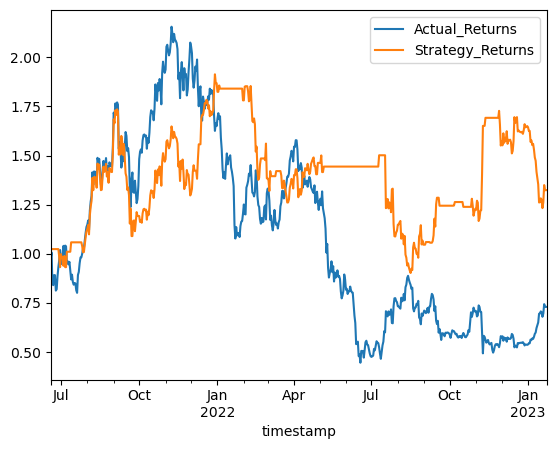

In [85]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot()

# XGB Boost ML Model

In [86]:
#XGB:
import pandas_ta as pa
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config 
set_config(transform_output = 'pandas')


m = combined_df_.copy()
m['RSI'] = pa.rsi(m.Close, length=16)
m.rename(columns = {'value':'FG value', 'position':'Signal'}, inplace = True)

# fill in na with 0
m.fillna(0, inplace=True)

# change -1 to 2 for short selling
m[m<0] = 2

In [87]:
# Identify Features and Target
X = m.drop(["Signal"], axis=1).shift().dropna()
y = m["Signal"][1:].copy()

In [88]:
#Create Pipelines

categorical_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),])
numeric_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())])

cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

full_processor = ColumnTransformer(transformers=[("numeric", numeric_pipeline, num_cols),("categorical", categorical_pipeline, cat_cols)])



In [89]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sklearn.model_selection import GridSearchCV

xgb_cl = xgb.XGBClassifier(colsample_bylevel=1, gamma=1, learning_rate= 1)

# Apply preprocessing

X_processed = full_processor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(y.values.reshape(-1, 1))


# Split the data to train and Test
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, stratify=y_processed, random_state=1)


# Fit
xgb_cl.fit(X_train, y_train)

# Predict
pred = xgb_cl.predict(X_test)


# Score
xgb_testing_report = classification_report(y_test, pred)
print(xgb_testing_report)


              precision    recall  f1-score   support

           0       0.84      0.84      0.84       123
           1       0.89      0.93      0.91       162
           2       0.81      0.78      0.79       169

    accuracy                           0.85       454
   macro avg       0.84      0.85      0.85       454
weighted avg       0.84      0.85      0.84       454



In [90]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = pred
predictions_df["predicted_signal"] = predictions_df["predicted_signal"].replace(2, -1)
predictions_df["Actual Returns"] = combined_df_["change"]
predictions_df["trading_algorithm_returns"] = predictions_df["Actual Returns"] * predictions_df["predicted_signal"]
predictions_df = predictions_df.sort_index()
predictions_df

,predicted_signal,Actual Returns,trading_algorithm_returns
timestamp,,,
2018-02-05 00:00:00+00:00,0,-0.163812,-0.000000
2018-02-06 00:00:00+00:00,-1,0.136358,-0.136358
2018-02-07 00:00:00+00:00,-1,-0.045458,0.045458
2018-02-08 00:00:00+00:00,-1,0.080229,-0.080229
2018-02-10 00:00:00+00:00,-1,-0.026531,0.026531
...,...,...,...
2023-01-13 00:00:00+00:00,1,0.023750,0.023750
2023-01-17 00:00:00+00:00,1,-0.005700,-0.005700
2023-01-20 00:00:00+00:00,1,0.069046,0.069046


<AxesSubplot: title={'center': 'Actual vs. XGB Model'}, xlabel='timestamp'>

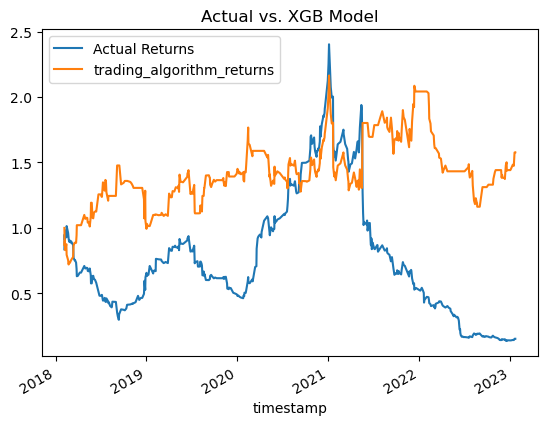

In [91]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["Actual Returns", "trading_algorithm_returns"]]).cumprod().plot(title= "Actual vs. XGB Model")
